#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 7 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2024

You are required to submit your mini-projects by midnight on 07/05/24. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
sys.path.append('./../')

In [2]:
from week6.utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


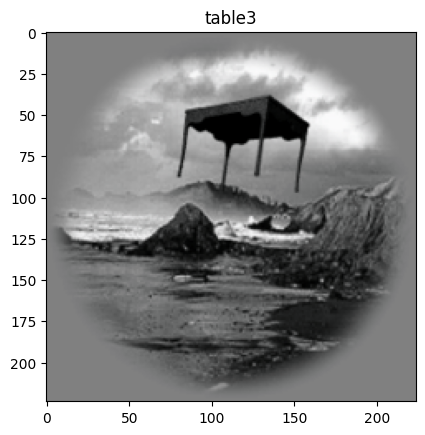

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

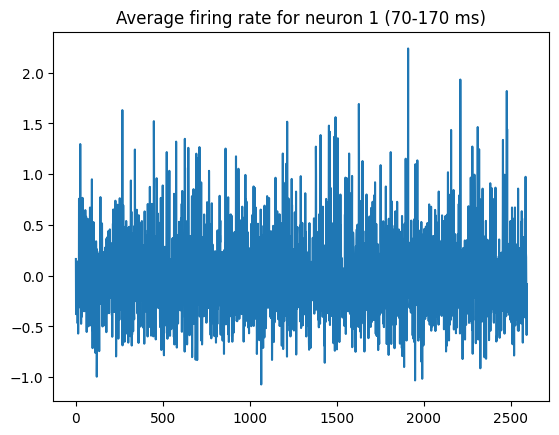

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Predict the neural activity using a data-driven approach

In the first part of the project, you have predicted the neural activity either from pixels or from the activations of a pre-trained neural network model. Here, your objective is to build and train a shallow convolutional neural network to predict the IT neural activity.

Follow these steps:
- Create the dataloader
- Define the model (Shallow CNN with 2/3 layers)
- Define the loss function (MSE) and the optimizer
- Build the training script and train your model
- Evaluate the predictions of your model. 
- Compare the neural predictions with the ones achieved by the task-trained neural network model. Which one can better predict the neural activity?

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

#Options class to define parameters
class Options:
    def __init__(self):
        self.learning_rate = 1e-6
        self.kernel_size = 3
        self.padding = 2
        self.epochs = 50
        self.batch_size= 16
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            # Taken from https://pytorch.org/docs/stable/notes/mps.html
            # Check that MPS is available
            if not torch.backends.mps.is_available():
                if not torch.backends.mps.is_built():
                    print("MPS not available because the current PyTorch install was not "
                        "built with MPS enabled.")
                    self.device = 'cpu'
                else:
                    print("MPS not available because the current MacOS version is not 12.3+ "
                        "and/or you do not have an MPS-enabled device on this machine.")
                    self.device = 'cpu'

            else:
                self.device = 'mps'
            
options = Options()

In [8]:
#Loading the data
train_dataloader = DataLoader(list(zip(stimulus_train, spikes_train)), batch_size=options.batch_size, shuffle=True)
val_dataloader = DataLoader(list(zip(stimulus_val, spikes_val)), batch_size=options.batch_size)

#Define a simple CNN with 2 convolution/pooling layers
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=options.kernel_size, padding=options.padding)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=options.kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 55 * 55, 168)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

#Define the loss and optimizer
model = CNNModel().to(options.device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=options.learning_rate)

In [9]:
#Train the network 
loss_array = np.array([])
for epoch in range(options.epochs):
    model.train()
    for inputs, targets in train_dataloader:
        inputs = inputs.to(options.device)
        targets = targets.to(options.device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    #Evaluate loss
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        for inputs, targets in val_dataloader:
            inputs = inputs.to(options.device)
            targets = targets.to(options.device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()
        val_loss = total_val_loss / len(val_dataloader)
        loss_array=np.append(loss_array,val_loss)
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

Epoch 1, Validation Loss: 0.1360
Epoch 2, Validation Loss: 0.1329
Epoch 3, Validation Loss: 0.1304
Epoch 4, Validation Loss: 0.1285
Epoch 5, Validation Loss: 0.1263
Epoch 6, Validation Loss: 0.1249
Epoch 7, Validation Loss: 0.1233
Epoch 8, Validation Loss: 0.1219
Epoch 9, Validation Loss: 0.1209
Epoch 10, Validation Loss: 0.1204
Epoch 11, Validation Loss: 0.1188
Epoch 12, Validation Loss: 0.1182
Epoch 13, Validation Loss: 0.1171
Epoch 14, Validation Loss: 0.1169
Epoch 15, Validation Loss: 0.1159
Epoch 16, Validation Loss: 0.1157
Epoch 17, Validation Loss: 0.1157
Epoch 18, Validation Loss: 0.1156
Epoch 19, Validation Loss: 0.1149
Epoch 20, Validation Loss: 0.1142
Epoch 21, Validation Loss: 0.1143
Epoch 22, Validation Loss: 0.1142
Epoch 23, Validation Loss: 0.1147
Epoch 24, Validation Loss: 0.1135
Epoch 25, Validation Loss: 0.1132
Epoch 26, Validation Loss: 0.1129
Epoch 27, Validation Loss: 0.1125
Epoch 28, Validation Loss: 0.1126
Epoch 29, Validation Loss: 0.1125
Epoch 30, Validation Lo

In [10]:
#Make predictions
stimulus_val_tensor = torch.from_numpy(stimulus_val).to(options.device)
predicted_spikes = model(stimulus_val_tensor)
predicted_spikes = predicted_spikes.to("cpu")

Text(0, 0.5, 'MSE loss')

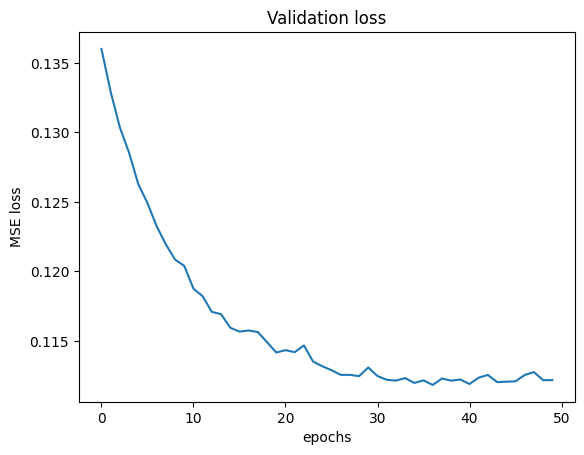

In [11]:
#Plot MSE loss across epochs
plt.plot(loss_array)
plt.title("Validation loss")
plt.xlabel("epochs")
plt.ylabel("MSE loss")

In [12]:
predicted_spikes = predicted_spikes.detach().numpy()

Text(0.5, 1.0, 'Prediction of firing rate for neuron 1')

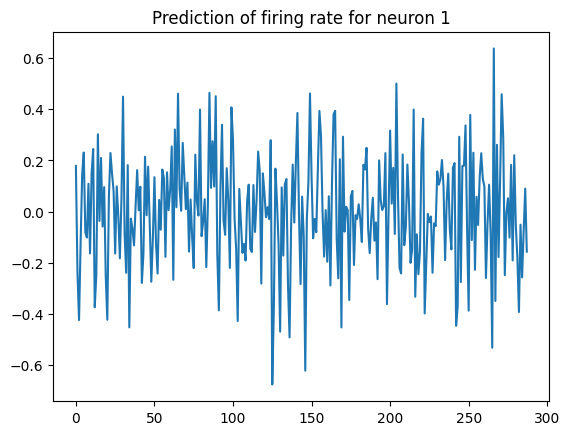

In [13]:
predicted_spikes_single = predicted_spikes[:,1]
plt.plot(predicted_spikes_single)
plt.title("Prediction of firing rate for neuron 1")

In [14]:
#Compute relevant metrics, explained variance and correlations across neurons
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

def evaluate_predictions(y_true, y_pred):
    correlations = []
    explained_variances = []
    n_neurons = y_true.shape[1]
    for i in range(n_neurons):
        correlation, _ = pearsonr(y_true[:, i], y_pred[:, i])
        explained_variance = r2_score(y_true[:, i], y_pred[:, i])
        correlations.append(correlation)
        explained_variances.append(explained_variance)
    return correlations, explained_variances

In [15]:
correlations, explained_variances = evaluate_predictions(spikes_val,predicted_spikes)

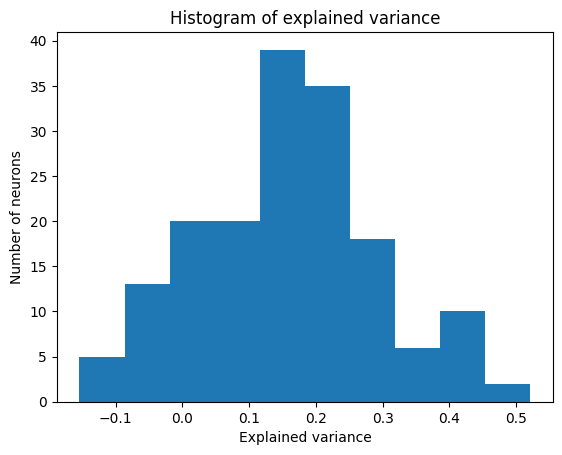

Mean :  0.1595953152594126
STDev :  0.1369998457490082


In [16]:
plt.hist(explained_variances)
plt.xlabel("Explained variance")
plt.ylabel("Number of neurons")
plt.title("Histogram of explained variance")
plt.show()
print("Mean : ",np.mean(explained_variances))
print("STDev : ",np.std(explained_variances))

Text(0.5, 0, 'Neuron ID')

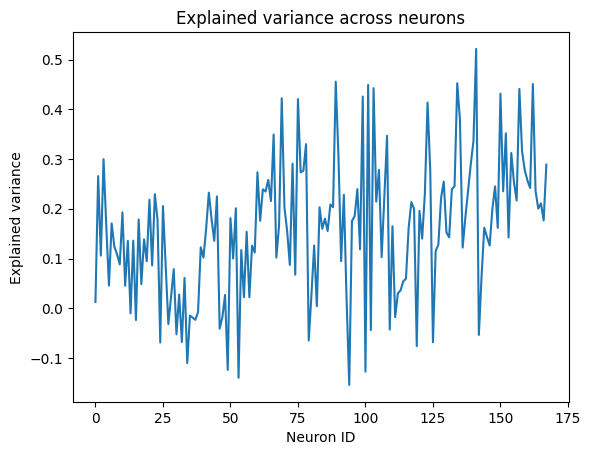

In [17]:
plt.plot(explained_variances)
plt.title("Explained variance across neurons")
plt.ylabel("Explained variance")
plt.xlabel("Neuron ID")

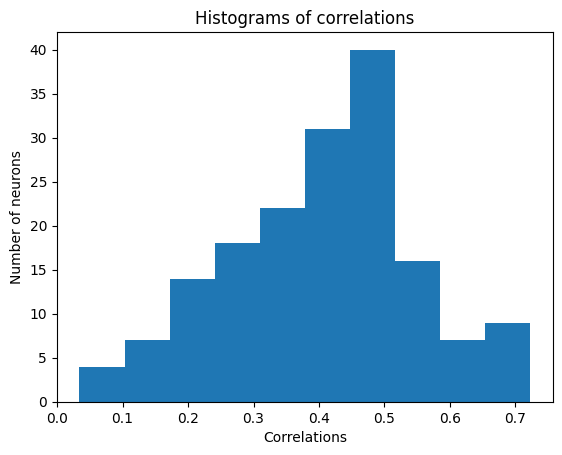

Mean :  0.4054192006521131
STDev :  0.14429064556343432


In [18]:
plt.hist(correlations)
plt.xlabel("Correlations")
plt.ylabel("Number of neurons")
plt.title("Histograms of correlations")
plt.show()
print("Mean : ",np.mean(correlations))
print("STDev : ",np.std(correlations))

Text(0.5, 0, 'Neuron ID')

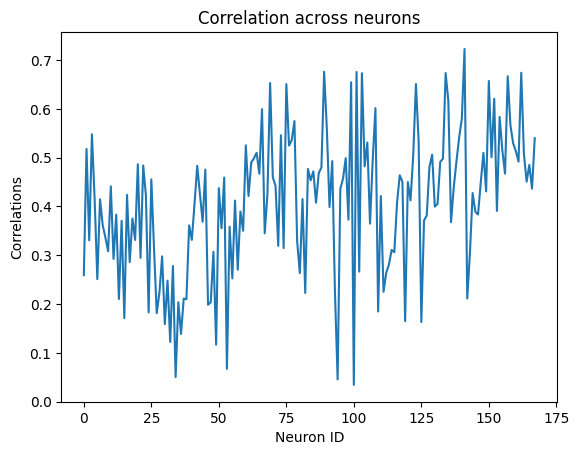

In [19]:
plt.plot(correlations)
plt.title("Correlation across neurons")
plt.ylabel("Correlations")
plt.xlabel("Neuron ID")